# LangGraph

In [55]:
import random
from typing import Literal
from IPython.display import Image, display
import os
from typing import TypedDict, List, Dict, Any, Optional

from langchain_ollama import OllamaLLM
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

from langgraph.graph import StateGraph, START, END

In [56]:
# model_name = "qwen3:1.7b"
model_name = "mistral:v0.3"

In [57]:
chat_model = ChatOllama(model=model_name)
print(chat_model.invoke("Who was the first man on the moon?"))

content=' Neil Armstrong, an American astronaut and aeronautical engineer, was the first man to walk on the Moon. He landed on July 20, 1969, as part of NASA\'s Apollo 11 mission, along with his fellow astronaut Buzz Aldrin. The famous words Armstrong spoke upon setting foot on the lunar surface were: "That\'s one small step for man, one giant leap for mankind."' additional_kwargs={} response_metadata={'model': 'mistral:v0.3', 'created_at': '2025-05-18T05:51:20.945466Z', 'done': True, 'done_reason': 'stop', 'total_duration': 10113283917, 'load_duration': 564197125, 'prompt_eval_count': 14, 'prompt_eval_duration': 4677844333, 'eval_count': 100, 'eval_duration': 4869505708, 'model_name': 'mistral:v0.3'} id='run--aa56cc7a-7aa7-4009-bbc4-b1da6fcedcb0-0' usage_metadata={'input_tokens': 14, 'output_tokens': 100, 'total_tokens': 114}


In [58]:
class State(TypedDict):
    graph_state: str

In [59]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

In [60]:
def decide_mood(state) -> Literal["node_2", "node_3"]:

    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state']

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"

    # 50% of the time, we return Node 3
    return "node_3"

In [61]:
# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

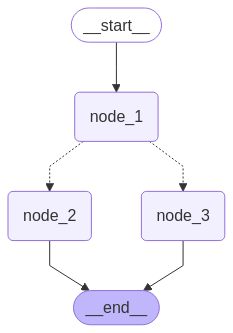

In [111]:
# View
Image(graph.get_graph().draw_mermaid_png())
# print(graph.get_graph().draw_ascii())

In [36]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 2---


{'graph_state': 'Hi, this is Lance. I am happy!'}

---
## Mini Project

In [78]:
class EmailState(TypedDict):
    email: Dict[str, Any]
    email_category: Optional[str]
    spam_reason: Optional[str]
    is_spam: Optional[bool]
    email_draft: Optional[str]
    messages: List[Dict[str, Any]]

In [79]:
chat_model = ChatOllama(model=model_name)

In [80]:
def read_email(state: EmailState):
    """Alfred reads and logs the incoming email"""
    email = state["email"]
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    return {}  # no state changes needed here

In [81]:
def classify_email(state: EmailState):
    """Alfred uses an LLM to determine if the email is spam or legit"""
    email = state['email']
    prompt = f"""
    As Alfred the butler, analyze this email and determine if it is spam or legitimate.

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    First, determine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).
    """
    messages = [HumanMessage(content=prompt)]
    response = chat_model.invoke(messages)  # call the LLM !

    response_text = response.content.lower()
    is_spam = 'spam' in response_text and 'not spam' not in response_text

    spam_reason = None
    if is_spam:
        spam_reason = 'kaha'
    if is_spam and 'reason:' in response_text:
        spam_reason = response_text.split('reason:')[1].strip()


    email_category = None
    if not is_spam:
        categories = ["inquiry", "complaint", "thank you", "request", "information"]
        for category in categories:
            if category in response_text:
                email_category = category
                break

    new_messages = state.get('messages', []) + [
        {'role': 'user', 'content': prompt},
        {'role': 'assistant', 'content': response.content}
    ]

    return {
        'is_spam': is_spam,
        'spam_reason': spam_reason,
        'email_category': email_category,
        'messages': new_messages
    }

In [82]:
def handle_spam(state: EmailState):
    """Alfred discards spam email with a note"""
    print(f'Alfred marked it as spam because {state['spam_reason']}')
    return {}

In [83]:
def draft_response(state: EmailState):
    """Alfred drafts a preliminary response for legit emails"""
    email = state['email']
    category = state['email_category'] or 'general'

    prompt = f"""
    As Alfred the butler, draft a polite preliminary response to this email.

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    This email has been categorized as: {category}

    Draft a brief, professional response that Mr. Hugg can review and personalize before sending.
    """

    messages = [HumanMessage(content=prompt)]
    response = chat_model.invoke(messages)  # LLM call !
    new_messages = state.get('messages', []) + [
        {'role': 'user', 'content': prompt},
        {'role': 'assistant', 'content': response.content},
    ]

    return {
        'email_draft': response.content,
        'messages': new_messages
    }

In [84]:
def notify_mr_hugg(state: EmailState):
    """Alfred notifies Mr. Hugg about the email and presents the draft response"""
    email = state['email']

    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["email_draft"])
    print("="*50 + "\n")

    return {}

In [85]:
def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state['is_spam']:
        return 'spam'
    else:
        return 'legit'

In [86]:
email_graph = StateGraph(EmailState)

# nodes
email_graph.add_node('read_email', read_email)
email_graph.add_node('classify_email', classify_email)
email_graph.add_node('handle_spam', handle_spam)
email_graph.add_node('draft_response', draft_response)
email_graph.add_node('notify_mr_hugg', notify_mr_hugg)

# edges
email_graph.add_edge(START, 'read_email')
email_graph.add_edge('read_email', 'classify_email')
email_graph.add_conditional_edges('classify_email', route_email, {
    'spam': 'handle_spam',
    'legit': 'draft_response'
})
email_graph.add_edge('handle_spam', END)
email_graph.add_edge('draft_response', 'notify_mr_hugg')
email_graph.add_edge('notify_mr_hugg', END)

# compile
compiled_graph = email_graph.compile()

In [87]:
# display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [88]:
# Example legitimate email
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Hugg, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

# Example spam email
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

In [91]:
# Process the legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from john.smith@example.com with subject: Question about your services
Alfred marked it as spam because kaha


In [90]:
# Process the spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing spam email...
Alfred is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
Alfred marked it as spam because kaha


In [102]:
# response = chat_model.invoke('Draw a cat with ascii')
response = chat_model.stream('What is DCOP?')
full_string = ''
for c in response:
    print(c.content, end='')
    full_string += c.content
print('\n\n--- end ---')
# print(full_string)

 DCOP stands for Distributed Change of Ownership Protocol. It's a protocol used in the service-oriented architecture (SOA) of the GNOME desktop environment, a popular desktop environment for Linux and Unix systems.

In simple terms, DCOP allows communication between different processes running on the same system, enabling them to interact with each other in a way that is similar to function calls within a single program. This makes it possible for various applications and applets to communicate with one another, improving the overall functionality of the desktop environment by allowing these components to work together seamlessly.

For instance, if you have an email client and a music player on your GNOME desktop, they can use DCOP to share information or even manipulate each other's state. For example, the music player could pause playback when you receive a new email. This inter-process communication is essential for creating a unified and seamless user experience.

In more recent ye